# HodoscopeDetectorPanel class

Create a new HodoscopeDetectorPanel class. So far we made the folllwing modifications:

 - Must check that it is consistent with TomOpt imports!

 - `m2_cost`, `resolution` and `efficiency` are now features of the `hodoscope` class. `HodoscopePanel` m2_cost, `resolution` and `efficiency` are obtained from the `Hodoscope`.

 - $x,y,z$ and $dx, dy$ spans are now regular `tensors` and not `nn.param`.
 
 - Modified the `x`, `y`, `xy` feature of `HodoscopeDetectorPanel`, to return the Hodoscope ones.
 - Because of cyclic imports issues, we had to not specify the type of `Hodoscope` in the `HodscopeDetectorPanel` file. Must change in the future!

 - Removed `nn.ModuleList` in the `Hodoscope.generate_init_panels`.

 - Added a `index` feature to the `HodoscopeDetectorPanel`. It is now possible to compute the z position of the `HodoscopeDetectorPanel` from the position of the `Hodoscope`. Now the $x,y,z$ position of the `HodoscopeDetectorPanel` is expressed as a function of the `Hodoscope` free parameters.
 
 - xyz_span hodoscope parameters are normal `tensors` and not `nn.Parameter` type `tensors` 

 - `realistic validation` is set to `False` (in `Hodoscope` class), as a temporary fix to empty `ScatterBatch` hits for the "side-by-side" hodoscope configuration
 

In [14]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from torch import Tensor, nn 
import torch
from tomopt.core import DEVICE
from tomopt.volume.layer import PassiveLayer 
from tomopt.volume import Volume
from torch import autograd

In [15]:

def simple_hodoscope_config() -> Volume:

    init_xyz_span, xyz_gap = [1.5, 1.5, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e3

    hods = [Hodoscope(init_xyz= [0., 0., z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                      ) for z in [1.5, 1.2]]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 2., size = 1., 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [0.5, 0.5, z], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res
                        ) for z in [0., -.3]]

    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([2,2]), 
                                                z = .2, size = 1., 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))


In [16]:
def get_overlap_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1., 1., .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e3

    hods = [Hodoscope(init_xyz= [xy, xy, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for xy, z in zip([0., 0.9], [1.3, 1.2])]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0.0,-0.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)

    return Volume(get_layers([hod_detector_above, hod_detector_below]))

## Normal hodoscope configuration

We start with the normal scenario where two hodosopes are placed on top of each other above and below the VOI. 
For this configuration, the optimisation runs with no emtpy `ScatterBatch` errors with `realistic_validation` set to True  

In [17]:
volume = simple_hodoscope_config()

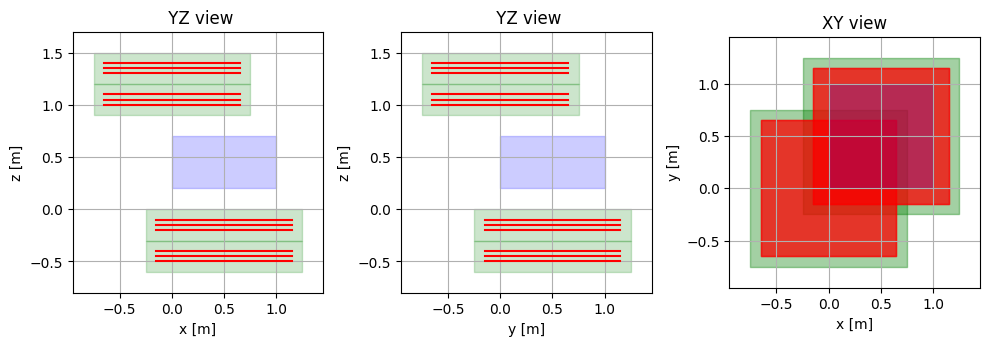

In [18]:
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

### Optimisation test 

In [19]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume

from tomopt.core import X0
from torch import Tensor

from functools import partial
from tomopt.optimisation import VoxelX0Loss

from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

In [20]:
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

In [21]:
from tomopt.optimisation import CostCoefWarmup, OptConfig, MuonResampler
from optimisation.hodoscope_callbacks import HodoscopeMetricLogger, NoMoreNaNs

ml = HodoscopeMetricLogger()

2 warmup callbacks found, with a total warmup period of 2 epochs.


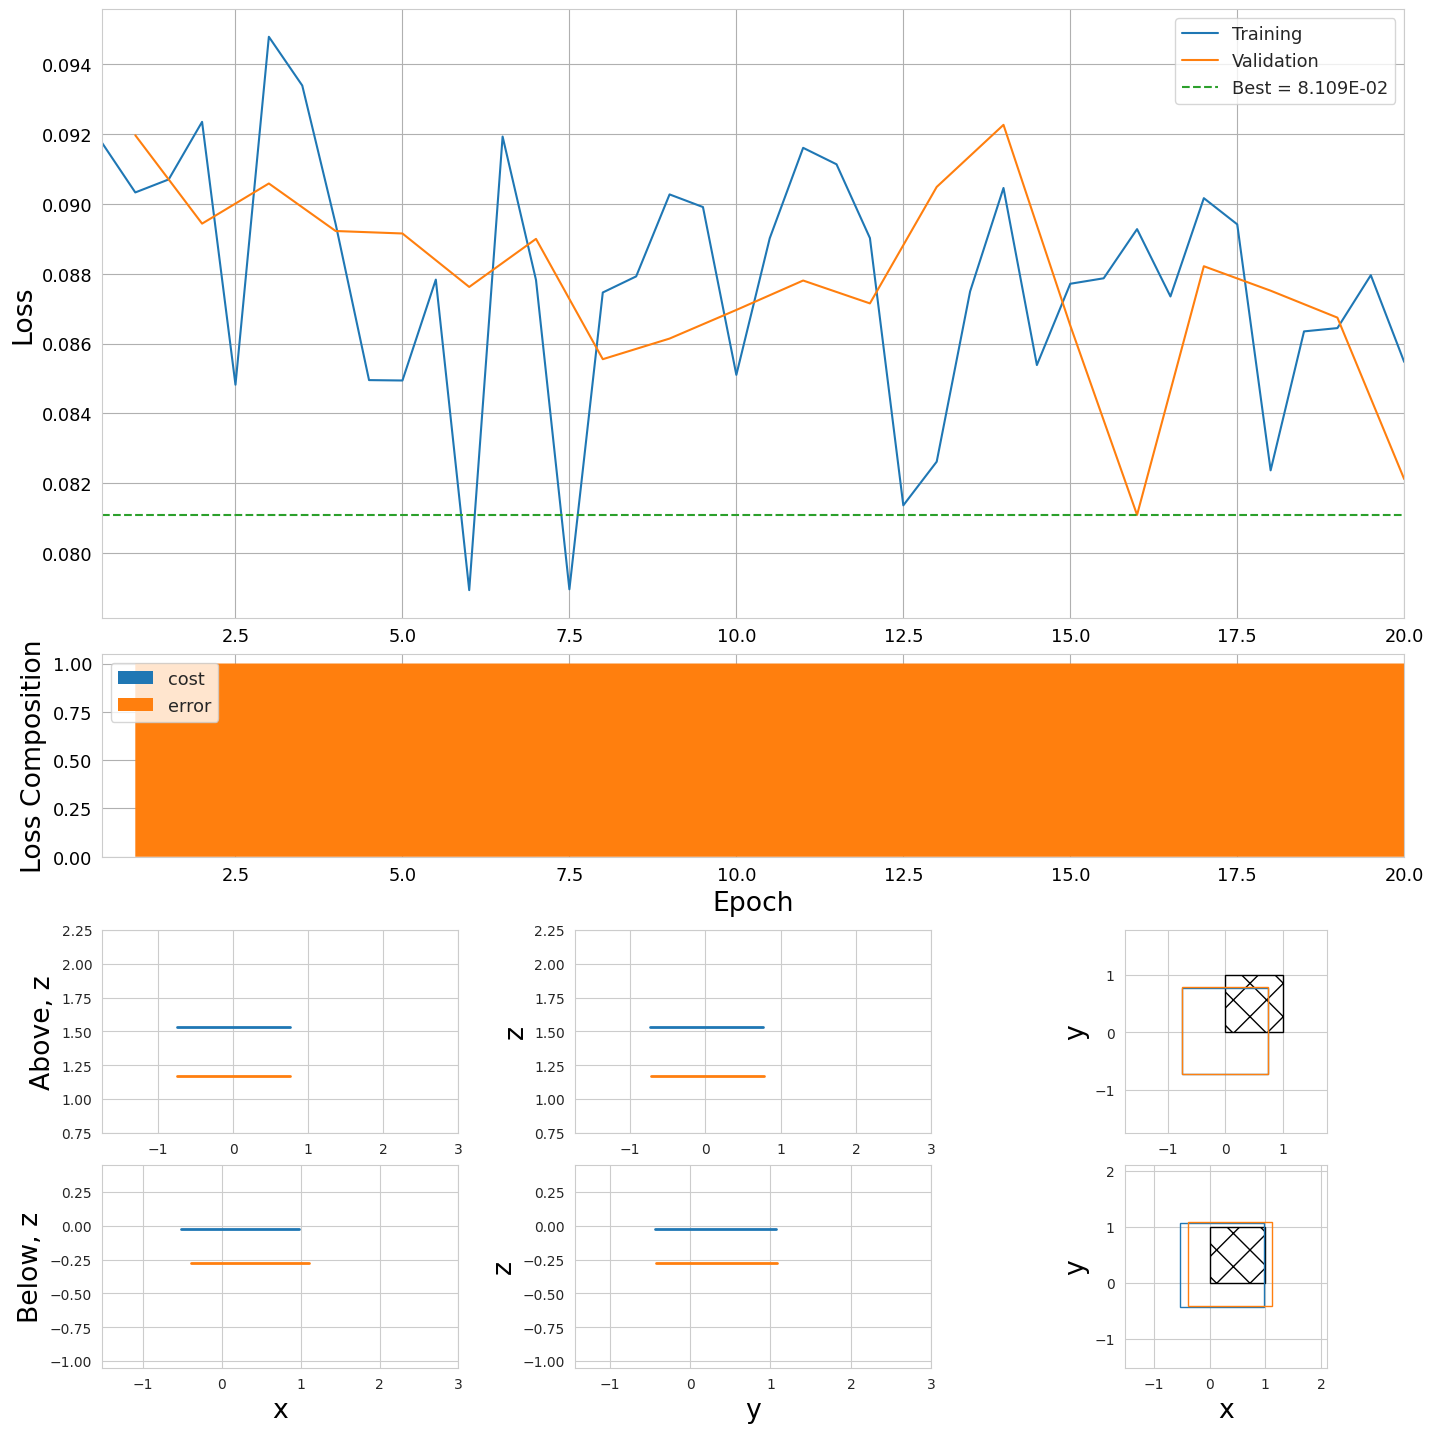

Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
In ScatterBATCH filter scatter
 n muons removed =  0
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter cont

<Figure size 1422.22x1422.22 with 0 Axes>

In [22]:
_ = wrapper.fit(n_epochs=20,
                passive_bs=1, 
                n_mu_per_volume=1000, 
                mu_bs=100, 
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=1), OptConfig(n_warmup=1, rates={'xy_pos_opt':0.01, 'z_pos_opt':0.005}), MuonResampler(), NoMoreNaNs(),ml])

## III - Ovelapping hodoscopes config

In this configuration, hodoscopes are placed side-by-side within the same `HodoscopeLayer`. 
Running the optimisation with `realistic_validation` set to `True` at first, we stumble on an error where all hits are filtered in the `ScatterBatch` class.
Setting `realistic_validation` to `False` seems a temporary fix.

In [23]:
volume = get_overlap_hod_config()

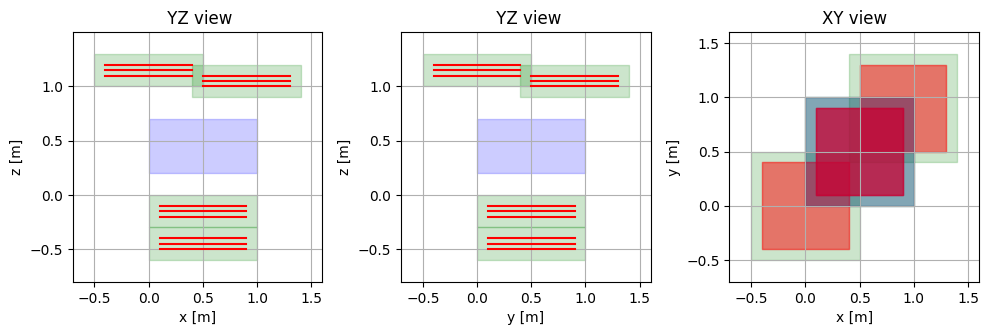

In [24]:
draw_volume_2D(volume)

In [25]:
wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

2 warmup callbacks found, with a total warmup period of 2 epochs.


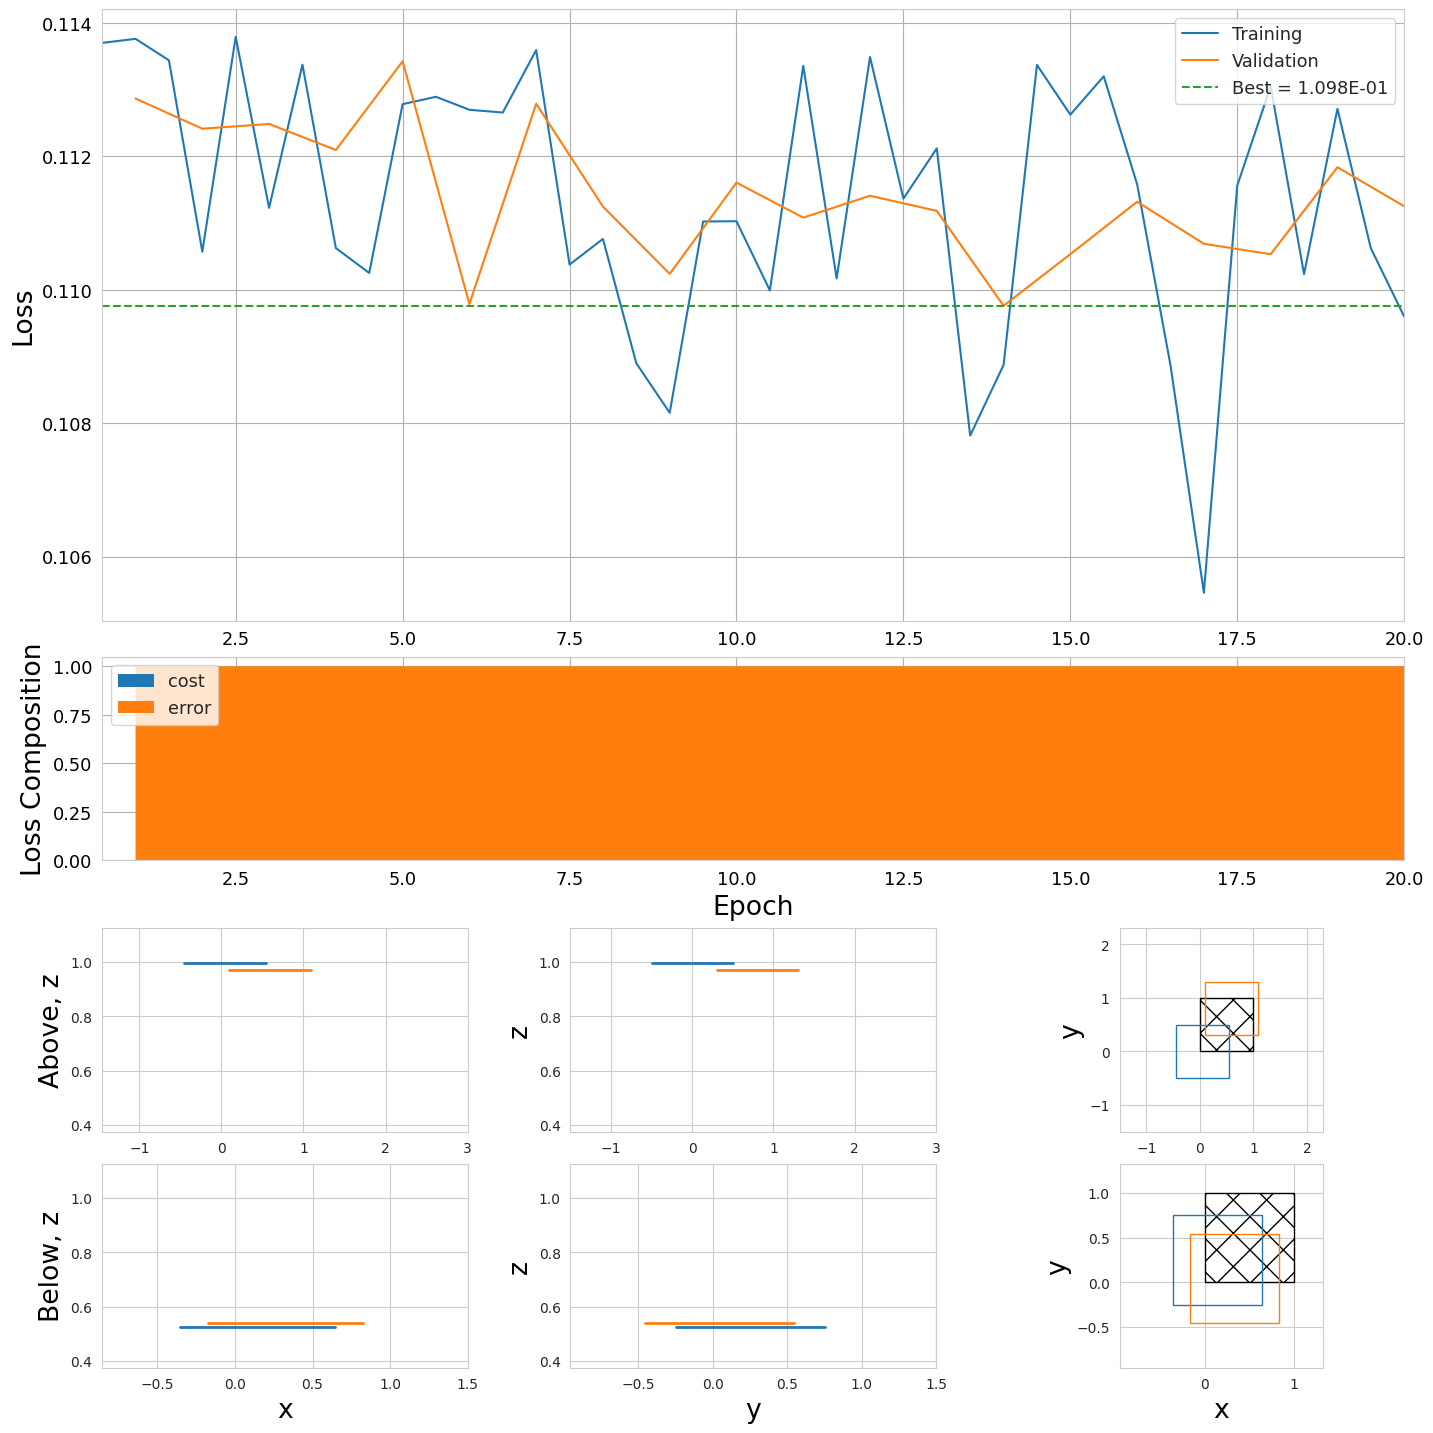

Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0.9000, 0.9000], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0.9000, 0.9000], requires_grad=True)
Parameter containing:
tensor([0.9000, 0.9000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
In ScatterBATCH filter scatter
 n muons removed =  5
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0., 0.], requires_grad=True)
Parameter containing:
tensor([0.9000, 0.9000], re

<Figure size 1422.22x1422.22 with 0 Axes>

In [26]:
_ = wrapper.fit(n_epochs=20,
                passive_bs=1, 
                n_mu_per_volume=1000, 
                mu_bs=100, 
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[CostCoefWarmup(n_warmup=1), OptConfig(n_warmup=1, rates={'xy_pos_opt':0.01, 'z_pos_opt':0.005}), MuonResampler(), NoMoreNaNs(),ml])